# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias_wkg = pd.DataFrame.from_csv('Udacity_AZDIAS_Subset.csv',sep=';',index_col=None)
cust_wkg = pd.DataFrame.from_csv('Udacity_CUSTOMERS_Subset.csv',sep=';',index_col=None)
azdias_wkg.shape

(891221, 85)

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

In [5]:
azdias_wkg[azdias_wkg['AGER_TYP']==int(0)].head(4)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
10,0,3,2,1.0,2,2,5,3,1,5,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0
278,0,3,2,5.0,5,1,5,1,2,2,...,3.0,2.0,1.0,0.0,1.0,3.0,3.0,1.0,3.0,1.0
417,0,4,1,2.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,4.0,6.0,3.0
445,0,4,1,3.0,5,1,5,1,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,3.0,7.0,3.0


In [8]:
# Load in the feature summary file.
feat_info = pd.DataFrame.from_csv('AZDIAS_Feature_Summary.csv',sep=';')
feat_info.head(8)

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]
FINANZ_SPARER,person,ordinal,[-1]
FINANZ_VORSORGER,person,ordinal,[-1]
FINANZ_ANLEGER,person,ordinal,[-1]


In [9]:
feat_info['new']=azdias_wkg.dtypes

In [10]:
feat_info.head(5)

,information_level,type,missing_or_unknown,new
attribute,,,,
AGER_TYP,person,categorical,"[-1,0]",int64
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",int64
ANREDE_KZ,person,categorical,"[-1,0]",int64
CJT_GESAMTTYP,person,categorical,[0],float64
FINANZ_MINIMALIST,person,ordinal,[-1],int64


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Identify missing or unknown data values and convert them to NaNs.  # azdias only

In [12]:
for x in feat_info.index:
    y = feat_info.missing_or_unknown[x]
    y = y.strip('][').split(',')
    for z in y:
        zz = 0
        try:
            zz = ast.literal_eval(z)
            azdias_wkg[x]=azdias_wkg.replace(zz,np.nan)[x]  #Replace 'NaN' with np.nan
            cust_wkg[x]=cust_wkg.replace(zz,np.nan)[x] 
        except:
            azdias_wkg[x]=azdias_wkg.replace(z,np.nan)[x]#Replace 'NaN' with np.nan
            cust_wkg[x]=cust_wkg.replace(z,np.nan)[x] 

### https://dzone.com/articles/pandas-find-rows-where-columnfield-is-null

In [13]:
null_columns=azdias_wkg.columns[azdias_wkg.isnull().any()]
print(azdias_wkg[null_columns].isnull().sum(),azdias_wkg[null_columns].isnull().sum()/azdias_wkg.shape[0])

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SHOPPER_TYP              111196
SOHO_KZ                   73499
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
WOHNDAUER_2008            73499
ANZ_HAUSHALTE_AKTIV       99611
ANZ_HH_TITEL              97008
GEBAEUDETYP               93148
KONSUMNAEHE               73969
                          ...  
OST_WEST

### https://matplotlib.org/gallery/statistics/histogram_multihist.html

In [14]:
azdias_wkg.to_pickle('az_wkg_1.pickle')
cust_wkg.to_pickle('cs_wkg_1')
feat_info.to_pickle('feat_wkg_1.pickle')

## CHECKPOINT 1

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
azdias_wkg = pd.read_pickle('az_wkg_1.pickle')
cust_wkg = pd.read_pickle('cs_wkg_1')
feat_wkg = pd.read_pickle('feat_wkg_1.pickle')

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

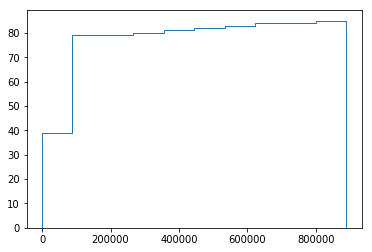

In [3]:
plt.hist([azdias_wkg.isnull().sum()],bins=10,cumulative=True,stacked=False, fill=False,histtype='step');

In [4]:
Na_pct =pd.DataFrame(azdias_wkg.isnull().sum()/azdias_wkg.shape[0],columns=['az pct'])
Cust_pct = pd.DataFrame(azdias_wkg.isnull().sum()/azdias_wkg.shape[0],columns=['az pct'])
Na_pct.sort_values('az pct',ascending=False).head(20)


,az pct
TITEL_KZ,0.997576
AGER_TYP,0.769554
KK_KUNDENTYP,0.655967
KBA05_BAUMAX,0.534687
GEBURTSJAHR,0.440203
ALTER_HH,0.348137
KKK,0.177357
REGIOTYP,0.177357
W_KEIT_KIND_HH,0.166051
KBA05_ANTG1,0.149597


In [5]:
dropcol = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']

azdias_wkg.drop(dropcol,axis=1,inplace=True)
cust_wkg.drop(dropcol,axis=1,inplace=True)
feat_wkg.drop(dropcol,axis=0,inplace=True)

In [6]:
azdias_wkg.head(4)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0


In [7]:
feat_wkg.sort_index().head(5)

,information_level,type,missing_or_unknown,new
attribute,,,,
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",int64
ANREDE_KZ,person,categorical,"[-1,0]",int64
ANZ_HAUSHALTE_AKTIV,building,numeric,[0],float64
ANZ_HH_TITEL,building,numeric,[],float64
ANZ_PERSONEN,household,numeric,[],float64


Investigate patterns in the amount of missing data in each column.
Notes:



#### Discussion 1.1.2: Assess Missing Data in Each Column

1) Top 6 columns are missing a significant amount of data so I have dropped these.
    
    TITEL_KZ	    >50% for both sets of data    - CAT.-
    AGER_TYP	    >50% for both sets of data   -  CAT - age typology (elderly) (other age categories avail.)
    KK_KUNDENTTYP   >50% for both sets of data   -  CAT - Cosumer pattern
    KBA05_BAUMAX    >50% for both sets of data   - 
    GEBURTSJAHR	    >25% for both sets of data    - Birth Year  (other age categories avail.)
    ALTER_HH        >25% for both sets of data    _ birth era of head of household

 
2) Groups of variables have between 10-25% missing data, these seems to be related, (i.e. there are whole sections missed by assumably the same people.  Waiting to see what we do with the row review to see if this gets cleaned up
    
    2a) Group 1
        HEALTH_TYP	111196	0.124768	48990	0.255620
        VERS_TYP	111196	0.124768	48990	0.255620
        SHOPPER_TYP	111196	0.124768	48990	0.255620

    2b)Group 2
            NATIONALITAET_KZ	108315	0.121536	48750	0.254367
        PRAEGENDE_JUGENDJAHRE	108164	0.121366	48487	0.252995

    2c) Group 3 (probably only need FEIN and GROB but not both)
        LP_LEBENSPHASE_FEIN	92778	0.104102	47840	0.249619
        LP_LEBENSPHASE_GROB	89718	0.100669	47728	0.249035
            LP_FAMILIE_GROB	72938	0.081841	47369	0.247162
            LP_FAMILIE_FEIN	72938	0.081841	47369	0.247162



Remove the outlier columns from the dataset. (You'll perform other data
engineering tasks such as re-encoding and imputation later.)

* NOTE: Removed columns listed in bullet 1) in above code

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [8]:
azdias_wkg.shape

(891221, 79)

#### Will create subset whereas all rows with >10% missing values will be removed

In [9]:
# How much data is missing in each row of the dataset?

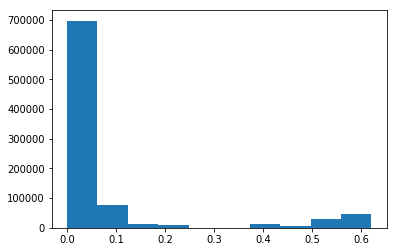

In [10]:
plt.hist(azdias_wkg.isnull().sum(axis=1)/azdias_wkg.shape[1]);


In [11]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row  Split at 10% missing data (i.e. keep all rows with <= 10% of entries missing)
azdias_above10 = azdias_wkg[azdias_wkg.isnull().sum(axis=1)/azdias_wkg.shape[1]>0.1]
azdias_beloweq10 = azdias_wkg[azdias_wkg.isnull().sum(axis=1)/azdias_wkg.shape[1]<=0.1]

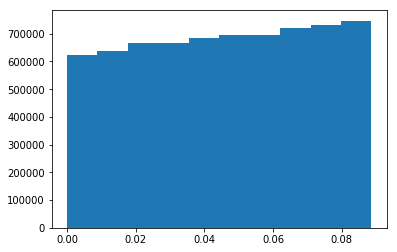

In [12]:
plt.hist(azdias_beloweq10.isnull().sum(axis=1)/azdias_beloweq10.shape[1],cumulative=True);

In [13]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
azdias_above10.isnull().sum().sort_values(ascending=True).head(25)

ZABEOTYP                   0
SEMIO_REL                  0
SEMIO_MAT                  0
SEMIO_VERT                 0
SEMIO_LUST                 0
SEMIO_ERL                  0
SEMIO_KULT                 0
SEMIO_RAT                  0
SEMIO_KRIT                 0
SEMIO_DOM                  0
SEMIO_KAEM                 0
GREEN_AVANTGARDE           0
SEMIO_PFLICHT              0
FINANZTYP                  0
FINANZ_HAUSBAUER           0
FINANZ_UNAUFFAELLIGER      0
FINANZ_ANLEGER             0
FINANZ_VORSORGER           0
FINANZ_SPARER              0
FINANZ_MINIMALIST          0
SEMIO_TRADV                0
ANREDE_KZ                  0
SEMIO_SOZ                  0
SEMIO_FAM                  0
ALTERSKATEGORIE_GROB     412
dtype: int64

In [14]:
azdias_beloweq10.isnull().sum().sort_values(ascending=True).head(25)

ZABEOTYP              0
SEMIO_REL             0
SEMIO_MAT             0
SEMIO_VERT            0
SEMIO_LUST            0
SEMIO_ERL             0
SEMIO_KULT            0
SEMIO_RAT             0
SEMIO_KRIT            0
SEMIO_FAM             0
SEMIO_DOM             0
SEMIO_PFLICHT         0
SEMIO_TRADV           0
OST_WEST_KZ           0
SOHO_KZ               0
MIN_GEBAEUDEJAHR      0
ANZ_PERSONEN          0
ANZ_TITEL             0
HH_EINKOMMEN_SCORE    0
SEMIO_KAEM            0
GEBAEUDETYP           0
SEMIO_SOZ             0
WOHNLAGE              0
ANREDE_KZ             0
CJT_GESAMTTYP         0
dtype: int64

In [15]:
concat = pd.concat([azdias_beloweq10.assign(dataset='less or eq 10%'), azdias_above10.assign(dataset='more than 10%')])

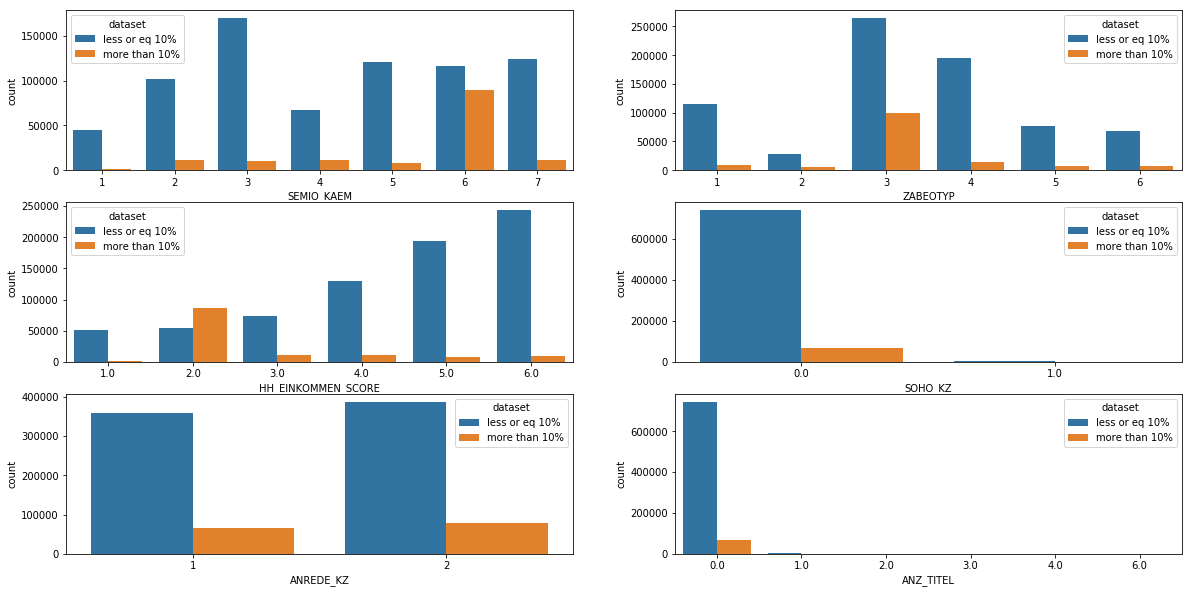

In [16]:
fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(20,10));
vars = ['SEMIO_KAEM','ZABEOTYP','HH_EINKOMMEN_SCORE','SOHO_KZ','ANREDE_KZ','ANZ_TITEL']
for idx,axx in enumerate(ax.ravel()):
    sns.countplot(x=vars[idx],data=concat,hue='dataset',ax=axx)


In [17]:

azdias_wkg = azdias_beloweq10

In [18]:
azdias_wkg.to_pickle('az_wkg_2.pickle')
feat_wkg.to_pickle('feat_wkg_2.pickle')

## CHECKPOINT 2

In [3]:
azdias_wkg = pd.read_pickle('az_wkg_2.pickle')
feat_wkg = pd.read_pickle('feat_wkg_2.pickle')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

{need more content}

Looks like ther eis some ditribution differences in teh data
Its difficult to discern because of the scaling.   
    SEMIO_KAEM certainly has a different distribution
    The rest look *similar* but its difficult to completely discern

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [4]:
# How many features are there of each data type?
# Load in the feature summary file.


In [5]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
print(feat_wkg.groupby('type').count())
ordinal = feat_wkg[feat_wkg['type']=='ordinal']
interval = feat_wkg[feat_wkg['type']=='interval']
categorical = feat_wkg[feat_wkg['type']=='categorical']
numerical = feat_wkg[feat_wkg['type']=='numeric']
mixed = feat_wkg[feat_wkg['type']=='mixed']


             information_level  missing_or_unknown  new
type                                                   
categorical                 18                  18   18
mixed                        6                   6    6
numeric                      6                   6    6
ordinal                     49                  49   49


 assess ordinal (categorical or numerical)  and sort into appropraite groups

In [6]:
ordinal.index

Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'KONSUMNAEHE', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_AB'],
      dtype='object', name='attribute')

In [7]:
categorical.index

Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'],
      dtype='object', name='attribute')

In [8]:
numerical.index

Index(['ANZ_PERSONEN', 'ANZ_TITEL', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'MIN_GEBAEUDEJAHR', 'KBA13_ANZAHL_PKW'],
      dtype='object', name='attribute')

In [9]:
mixed.index

Index(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
       'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'],
      dtype='object', name='attribute')

In [10]:
# Separate clearly ordinal from ambiguously ordinal

ordinal_interval_1 = pd.Index(['KONSUMNAEHE',
                             'ORTSGR_KLS9',
                             'WOHNDAUER_2008',
                             'PLZ8_GBZ',
                             'PLZ8_HHZ',
                             'KBA05_GBZ',
                             'ALTERSKATEGORIE_GROB',
                             'INNENSTADT',
                             'BALLRAUM',
                             'EWDICHTE'],dtype=object,name='attribute')

ordinal_amb = ['FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER','FINANZ_ANLEGER',
               'FINANZ_UNAUFFAELLIGER','FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','SEMIO_SOZ',
               'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST','SEMIO_ERL',
               'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM','SEMIO_KAEM', 'SEMIO_PFLICHT',
               'SEMIO_TRADV','HH_EINKOMMEN_SCORE','W_KEIT_KIND_HH','KBA05_ANTG1','KBA05_ANTG2',
               'KBA05_ANTG3', 'KBA05_ANTG4','KKK','MOBI_REGIO','ONLINE_AFFINITAET','PLZ8_ANTG1', 
               'PLZ8_ANTG2','PLZ8_ANTG3', 'PLZ8_ANTG4','ARBEIT','RELAT_AB']

In [11]:
ordinal_interval_1.tolist()

['KONSUMNAEHE',
 'ORTSGR_KLS9',
 'WOHNDAUER_2008',
 'PLZ8_GBZ',
 'PLZ8_HHZ',
 'KBA05_GBZ',
 'ALTERSKATEGORIE_GROB',
 'INNENSTADT',
 'BALLRAUM',
 'EWDICHTE']

In [12]:
interval= interval.append(ordinal.loc[(ordinal_interval_1),:])
ordinal = ordinal.drop(ordinal_interval_1,axis=0)

In [13]:
categorical = categorical.append(ordinal)

In [14]:
feat_wkg.loc[categorical.index,'type']='categorical'

In [15]:
feat_wkg.loc[ordinal_interval_1.tolist(),'type']='numeric'

In [16]:
feat_wkg.groupby('type').count()

,information_level,missing_or_unknown,new
type,,,
categorical,57,57,57
mixed,6,6,6
numeric,16,16,16


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [17]:
# 1) Idenitify two level categoricals  ]
categorical.index

Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'HEALTH_TYP',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'ARBEIT', 'RELAT_AB'],
      dt

In [18]:
CAT_DROP = ['CAMEO_DEUG_2015','LP_FAMILIE_FEIN','LP_STATUS_FEIN']
MIX_DROP = ['LP_LEBENSPHASE_FEIN']
# Dropping 1.11, 1.13, and 1.15 because there are similar gross scales.  
# Dropping 4.1 because there are three Cameos all the same. 4.1 is a gross scale similar ot 1.12 but the fine scale 4.2 contained additional descriptors that are not found other places in the data dictionar that can be useful to marketing
# 4.3 also contains similar gross scale

In [19]:
CAT_DROP = ['CAMEO_DEUG_2015','LP_FAMILIE_FEIN','LP_STATUS_FEIN']
MIX_DROP = ['LP_LEBENSPHASE_FEIN']
categorical.drop(CAT_DROP,axis=0)
mixed.drop(MIX_DROP,axis=0)
feat_wkg.drop(CAT_DROP,axis=0)
feat_wkg.drop(MIX_DROP,axis=0)
azdias_wkg.drop(CAT_DROP,axis=1)
azdias_wkg.drop(MIX_DROP,axis=1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2,1.0,2,2,5,3,1,5,6,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


In [20]:
azdias_wkg.columns[azdias_wkg[categorical.index].nunique()==2]


/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/base.py:1700: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 79 but corresponding boolean dimension is 57
  result = getitem(key)


Index(['ALTERSKATEGORIE_GROB', 'FINANZ_SPARER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_FAMILIE_FEIN'],
      dtype='object')

In [21]:
cat_to_bin = list(azdias_wkg[categorical.index].nunique().index[azdias_wkg[categorical.index].nunique()==2])

azdias_wkg[cat_to_bin].info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747109 entries, 1 to 891220
Data columns (total 5 columns):
ANREDE_KZ           747109 non-null int64
GREEN_AVANTGARDE    747109 non-null int64
SOHO_KZ             747109 non-null float64
VERS_TYP            722753 non-null float64
OST_WEST_KZ         747109 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 34.2+ MB


In [22]:
#2) One binary level variable is non numeric, find it and oen hot or encode it (O , W)

In [23]:
print(azdias_wkg[azdias_wkg['OST_WEST_KZ']=='W']['OST_WEST_KZ'].count())
print(azdias_wkg[azdias_wkg['OST_WEST_KZ']=='O']['OST_WEST_KZ'].count())

azdias_wkg['OST_WEST_KZ'].replace(['O','W'],[int(1),int(2)],inplace=True)

print(azdias_wkg[azdias_wkg['OST_WEST_KZ']==1]['OST_WEST_KZ'].count())
print(azdias_wkg[azdias_wkg['OST_WEST_KZ']==2]['OST_WEST_KZ'].count())

categorical_sans_bin = categorical.drop(cat_to_bin)
cat_onehotlist = list(categorical_sans_bin.index)

587514
159595
159595
587514


In [24]:
# Re-encode categorical variable(s) to be kept in the analysis
azdias_wkg = pd.get_dummies(azdias_wkg,columns=cat_onehotlist)

In [25]:
azdias_wkg.to_pickle('az_wkg_3.pickle')

In [26]:
feat_wkg.to_pickle('feat_wkg_3.pickle')

## CHECKPOINT 3

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
azdias_wkg = pd.read_pickle('az_wkg_3.pickle')
feat_wkg = pd.read_pickle('feat_wkg_3.pickle')


In [3]:
#### make this work with above
print(feat_wkg.groupby('type').count())
ordinal = feat_wkg[feat_wkg['type']=='ordinal']
categorical = feat_wkg[feat_wkg['type']=='categorical']
numerical = feat_wkg[feat_wkg['type']=='numeric']
mixed = feat_wkg[feat_wkg['type']=='mixed']


             information_level  missing_or_unknown  new
type                                                   
categorical                 57                  57   57
mixed                        6                   6    6
numeric                     16                  16   16


#### Discussion 1.2.1: Re-Encode Categorical Features

1) Binary categories were identified (cat_to_bin).  OST_WEST_KZ was identified as having a non_numerical category  Was recoded with O= 1 and W =2.  

2) remainder of categorical data was one hot encoded.  

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [4]:
mixed

,information_level,type,missing_or_unknown,new
attribute,,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0],float64
LP_LEBENSPHASE_GROB,person,mixed,[0],float64
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]",int64
WOHNLAGE,building,mixed,[-1],float64
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]",object
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]",float64


In [5]:
mixed.loc['test',:] = ['building','mixed','missing_or_unknown','float64']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
mixed.loc['test',:].values

array(['building', 'mixed', 'missing_or_unknown', 'float64'], dtype=object)

Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
Keep orginal column, and add two more movement (mainstreem, avantgarge) and locale (E,W,Both)

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

#### 1.18.1. PRAEGENDE_JUGENDJAHRE_MVMT
- 0: unknown
- 1: Mainstream
- 2: Avantgarde

#### 1.18.2. PRAEGENDE_JUGENDJAHRE_LOC
- 0: unknown
- 1: east
- 2: west
- 3: both

#### 1.18.3 PRAEGENDE_JUGENDJAHRE_DEC
- 0: unknown
- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s


Investigate "CAMEO_INTL_2015" and engineer two new variables.
split into two, remove orginal column.
this can be done by splitting the string of the category into two separate digits.  

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

#### 4.3.1 CAMEO_INTL_2015_WEALTH
- 0: unknown
- 1: Wealthy Households
- 2: Prosperous Households
- 3: Comfortable Households
- 4: Less Affluent Households
- 5: Poorer Households

#### 4.3.2 CAMEO_INTL_2015_TYPE
- 0: unknown
- 1: Pre-Family Couples & Singles
- 2: Young Couples With Children
- 3: Families With School Age Children
- 4: Older Families &  Mature Couples
- 5: Elders In Retirement

In [7]:
CAM_col = 'CAMEO_INTL_2015'
CAM_col_a = CAM_col + '_WEALTH'
CAM_col_b = CAM_col + '_FAM_TYPE'

In [8]:
PJ_new = {1: [1,3,1],2: [2,3,1],3: [1,3,2],4: [2,3,2],5: [1,3,3],6: [2,2,3],7: [2,1,3],8: [1,3,4],
          9: [2,3,4],10: [1,2,5],11: [2,2,5],12: [1,1,5],13: [2,1,5],14: [1,3,6],15: [2,3,6]}

In [9]:
PJcol = 'PRAEGENDE_JUGENDJAHRE'
PJcol_a = PJcol+'_MVMT'
PJcol_b = PJcol+'_LOC'
PJcol_c = PJcol+'_DEC'

In [10]:
def return_single_char(row,column,digit):
    if (isinstance(row[column],str)) and (len(row[column]) == 2):
        return row[column][digit]
    else:
        return np.nan

def return_lib_list(row,column,lib,index=0):
    if (not np.isnan(row[column])):
        return lib[int(row[column])][index]
    else:
        return np.nan

In [11]:
azdias_wkg[PJcol_a] = azdias_wkg.apply(lambda row: return_lib_list(row,PJcol,PJ_new,0),axis=1)

In [12]:
azdias_wkg[PJcol_b] = azdias_wkg.apply(lambda row: return_lib_list(row,PJcol,PJ_new,1),axis=1)
azdias_wkg[PJcol_c] = azdias_wkg.apply(lambda row: return_lib_list(row,PJcol,PJ_new,2),axis=1)

In [13]:
azdias_wkg[CAM_col_a] = azdias_wkg.apply(lambda row: return_single_char(row,CAM_col,0),axis=1)
azdias_wkg[CAM_col_b] = azdias_wkg.apply(lambda row: return_single_char(row,CAM_col,1),axis=1)

In [14]:
azdias_wkg = azdias_wkg.drop([CAM_col,PJcol],axis=1)

In [15]:
PJfeat = feat_wkg.loc[PJcol,:].values
CAMfeat = feat_wkg.loc[CAM_col,:].values

In [16]:
feat_wkg.loc[PJcol_a,:] = PJfeat
feat_wkg.loc[PJcol_b,:] = PJfeat
feat_wkg.loc[PJcol_c,:] = PJfeat
feat_wkg.loc[CAM_col_a,:] = CAMfeat
feat_wkg.loc[CAM_col_b,:] = CAMfeat

In [17]:
feat_wkg = feat_wkg.drop([CAM_col,PJcol],axis=0)

In [18]:
feat_wkg[feat_wkg['type']=='mixed']

,information_level,type,missing_or_unknown,new
attribute,,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0],float64
LP_LEBENSPHASE_GROB,person,mixed,[0],float64
WOHNLAGE,building,mixed,[-1],float64
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]",float64
PRAEGENDE_JUGENDJAHRE_MVMT,person,mixed,"[-1,0]",int64
PRAEGENDE_JUGENDJAHRE_LOC,person,mixed,"[-1,0]",int64
PRAEGENDE_JUGENDJAHRE_DEC,person,mixed,"[-1,0]",int64
CAMEO_INTL_2015_WEALTH,microcell_rr4,mixed,"[-1,XX]",object
CAMEO_INTL_2015_FAM_TYPE,microcell_rr4,mixed,"[-1,XX]",object


In [19]:
mix_onehotlist = list(feat_wkg[feat_wkg['type']=='mixed'].index)
mix_onehotlist

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'WOHNLAGE',
 'PLZ8_BAUMAX',
 'PRAEGENDE_JUGENDJAHRE_MVMT',
 'PRAEGENDE_JUGENDJAHRE_LOC',
 'PRAEGENDE_JUGENDJAHRE_DEC',
 'CAMEO_INTL_2015_WEALTH',
 'CAMEO_INTL_2015_FAM_TYPE']

In [20]:
azdias_wkg = pd.get_dummies(azdias_wkg,columns=mix_onehotlist)

In [21]:
azdias_wkg.shape

(747109, 455)

In [22]:
azdias_wkg.to_pickle('az_wkg_4.pickle')
feat_wkg.to_pickle('feat_wkg_4.pickle')

#### Discussion 1.2.2: Engineer Mixed-Type Features
PRAEGENDE_JUGENDJAHRE
- I created threesubclasses, which I called movement(MVMT) for avantgarde vs mainstreem and locale (LOC) for east, west or both, and DEC for decade. Dropped the original column

CAMEO_INTL_2015 
- I split into two separate categoies and dropped the original, since this category was purely all combinations of an intercsectio of two categories.  So i split this category into wealth and family type, and dropped the original.

REMAINDER
- The 5 resultant categories above will be one hot encoded with the other categorical variables.

- LP_LEBENSPHASE_FEIN - Iformation is mostly in CAMEO_INTL_2015, - so i didnt see a need to parse this into separate categories and left as is.  -> Categorical so we will one hot encode this.

- #LP_...._GROB - second dimention is reference to fine scale.  No evidence that scale is linear or otherwise so will leave as is for now.  I guess an argument can be made that this is ordinal.  The fine scale is not linear with the category numbers, but I will leave as is but move to ordinal.

- WOHNLAGE - little value splitting into two dimentions - would only benifit one of the several options. Leave as categorical and one hot encode. 

- Same as WOHNLAGE - may be able to convert to numerical but will leave as categorical for now. one hot encode.


## Checkpoint 4

In [23]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# magic word for producing visualizations in notebook
%matplotlib inline


In [24]:
azdias_wkg = pd.read_pickle('az_wkg_4.pickle')
feat_wkg = pd.read_pickle('feat_wkg_4.pickle')


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.  



In [25]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


# Note, I converted the ordinal to numerical or categorical above.



*SAvE FOR LATER

Using normality test per https://gist.github.com/syahdeini/0fc3b1b88444f04ea4b3.js

from scipy import stats

azdias_wkg.loc[:,(ordinal_amb[1])].isnull().sum()

k,p=stats.mstats.normaltest(azdias_wkg.loc[:,(ordinal_amb[1])])

for xx in ordinal.index:
    print(xx)
    k,p=stats.mstats.normaltest(azdias_wkg.loc[:,(xx)])
    if p < 0.5:
        ordinal.loc[(xx),('normal')]=True
    elif p <= 0.5:
        ordinal.loc[(xx),('normal')]=False
    else:
        print('Error detecting normality in: ', xx)


In [26]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

feat_wkg

,information_level,type,missing_or_unknown,new
attribute,,,,
ALTERSKATEGORIE_GROB,person,numeric,"[-1,0,9]",int64
ANREDE_KZ,person,categorical,"[-1,0]",int64
CJT_GESAMTTYP,person,categorical,[0],float64
FINANZ_MINIMALIST,person,categorical,[-1],int64
FINANZ_SPARER,person,categorical,[-1],int64
FINANZ_VORSORGER,person,categorical,[-1],int64
FINANZ_ANLEGER,person,categorical,[-1],int64
FINANZ_UNAUFFAELLIGER,person,categorical,[-1],int64
FINANZ_HAUSBAUER,person,categorical,[-1],int64


In [27]:
whos

Variable             Type         Data/Info
-------------------------------------------
CAM_col              str          CAMEO_INTL_2015
CAM_col_a            str          CAMEO_INTL_2015_WEALTH
CAM_col_b            str          CAMEO_INTL_2015_FAM_TYPE
CAMfeat              ndarray      4: 4 elems, type `object`, 32 bytes
PJ_new               dict         n=15
PJcol                str          PRAEGENDE_JUGENDJAHRE
PJcol_a              str          PRAEGENDE_JUGENDJAHRE_MVMT
PJcol_b              str          PRAEGENDE_JUGENDJAHRE_LOC
PJcol_c              str          PRAEGENDE_JUGENDJAHRE_DEC
PJfeat               ndarray      4: 4 elems, type `object`, 32 bytes
ast                  module       <module 'ast' from '/opt/<...>da/lib/python3.6/ast.py'>
azdias_wkg           DataFrame            ALTERSKATEGORIE_G<...>47109 rows x 455 columns]
categorical          DataFrame                          inf<...>B               float64  
feat_wkg             DataFrame                             <

## LOAD CHECKPOINT 5

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

azdias_wkg = pd.read_pickle('az_wkg_4.pickle')
feat_wkg = pd.read_pickle('feat_wkg_4.pickle')

ordinal = feat_wkg[feat_wkg['type']=='ordinal']
categorical = feat_wkg[feat_wkg['type']=='categorical']
numerical = feat_wkg[feat_wkg['type']=='numeric']
mixed = feat_wkg[feat_wkg['type']=='mixed']

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [2]:
def clean_data(df,df_feat):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # 1. convert missing value codes into NaNs, ...
    
    for x in df_feat.index:
        y = df_feat.missing_or_unknown[x]
        y = y.strip('][').split(',')
        for z in y:
            zz = 0
            try:
                zz = ast.literal_eval(z)
                df[x]=df.replace(zz,np.nan)[x]      #Replace 'NaN' with np.nan
            except:
                df[x]=df.replace(z,np.nan)[x]       #Replace 'NaN' with np.nan
    
    # 2. remove selected columns (dropcol) from df_feat and df

    dropcol = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    df = df.drop(dropcol,axis=1)
    df_feat = df_feat.drop(dropcol,axis=0)

    # 3. keep only rows with #N/As <= 10% of columns
    df = df[df.isnull().sum(axis=1)/df.shape[1]<=0.1]
       
    # 4. select, re-encode, and engineer column values.
    ordinal = df_feat[df_feat['type']=='ordinal']
    categorical = df_feat[df_feat['type']=='categorical']
    interval = df_feat[df_feat['type']=='interval']
    numerical = df_feat[df_feat['type']=='numeric']
    mixed = df_feat[df_feat['type']=='mixed']

    # 4.1  Sort ordinal features into interval and categorical.
    #    assign interval to numerical and the rest to categorical
    ord_int = pd.Index(['KONSUMNAEHE',
                             'ORTSGR_KLS9',
                             'WOHNDAUER_2008',
                             'PLZ8_GBZ',
                             'PLZ8_HHZ',
                             'KBA05_GBZ',
                             'ALTERSKATEGORIE_GROB',
                             'INNENSTADT',
                             'BALLRAUM',
                             'EWDICHTE'],dtype=object,name='attribute')
    
    interval = interval.append(ordinal.loc[(ord_int),:])
    ordinal = ordinal.drop(ord_int,axis=-0)
    categorical = categorical.append(ordinal)
    df_feat.loc[categorical.index,'type']='categorical'
    df_feat.loc[ord_int.tolist(),'type']='numeric'
    
    # Removed undesired cat features
    
       #
    CAT_DROP = ['CAMEO_DEUG_2015','LP_FAMILIE_FEIN','LP_STATUS_FEIN']
    MIX_DROP = ['LP_LEBENSPHASE_FEIN']
    categorical.drop(CAT_DROP,axis=0)
    mixed.drop(MIX_DROP,axis=0)
    df_feat.drop(CAT_DROP,axis=0)
    df_feat.drop(MIX_DROP,axis=0)
    df.drop(CAT_DROP,axis=1)
    df.drop(MIX_DROP,axis=1)
    
    # 4.2 - Identify binary categorical and convert string values to int
    cat_to_bin = ['ANREDE_KZ','OST_WEST_KZ','VERS_TYP','SOHO_KZ','GREEN_AVANTGARDE']
    df['OST_WEST_KZ'].replace(['O','W'],[int(1),int(2)],inplace=True)
    
 
    
    # One Hot encode all non-binary categoricals
    categorical_sans_bin = categorical.drop(cat_to_bin)
    cat_onehotlist = list(categorical_sans_bin.index)
    df = pd.get_dummies(df,columns=cat_onehotlist)
    
    #Reengineer Mixed type [PRAEGENDE_JUGENDJAHRE] and [CAMEO_INTL_2015]
    
    #functions required for the mixed reengineering below
    
    def return_single_char(row,column,digit):
        if (isinstance(row[column],str)) and (len(row[column]) == 2):
            return row[column][digit]
        else:
            return np.nan

    def return_lib_list(row,column,lib,index=0):
        if (not np.isnan(row[column])):
            return lib[int(row[column])][index]
        else:
            return np.nan
    
    #reengineer [PRAEGENDE_JUGENDJAHRE] into 3 columns that are defined by the dictionary PJnew
    PJ_new = {1: [1,3,1],2: [2,3,1],3: [1,3,2],4: [2,3,2],5: [1,3,3],6: [2,2,3],7: [2,1,3],8: [1,3,4],
          9: [2,3,4],10: [1,2,5],11: [2,2,5],12: [1,1,5],13: [2,1,5],14: [1,3,6],15: [2,3,6]}
    PJcol = 'PRAEGENDE_JUGENDJAHRE'
    PJcol_a = PJcol+'_MVMT'
    PJcol_b = PJcol+'_LOC'
    PJcol_c = PJcol+'_DEC'

    df[PJcol_a] = df.apply(lambda row: return_lib_list(row,PJcol,PJ_new,0),axis=1)
    df[PJcol_b] = df.apply(lambda row: return_lib_list(row,PJcol,PJ_new,1),axis=1)
    df[PJcol_c] = df.apply(lambda row: return_lib_list(row,PJcol,PJ_new,2),axis=1)
    

    #rengineer CAMERO_INTL_2015 based on wealth and family typ ewhich can be identified by splitting the I.D. character in two
    CAM_column = 'CAMEO_INTL_2015'
    CAM_column_a = CAM_column + '_WEALTH'
    CAM_column_b = CAM_column + '_FAM_TYPE'

    df[CAM_column_a] = df.apply(lambda row: return_single_char(row,CAM_column,0),axis=1)
    df[CAM_column_b] = df.apply(lambda row: return_single_char(row,CAM_column,1),axis=1)    
    
    df = df.drop([CAM_column,PJcol],axis=1)
    
    PJfeat = df_feat.loc[PJcol,:].values
    CAMfeat = df_feat.loc[CAM_column,:].values

    df_feat.loc[PJcol_a,:] = PJfeat
    df_feat.loc[PJcol_b,:] = PJfeat
    df_feat.loc[PJcol_c,:] = PJfeat
    df_feat.loc[CAM_column_a,:] = CAMfeat
    df_feat.loc[CAM_column_b,:] = CAMfeat

    df_feat = df_feat.drop([CAM_column,PJcol],axis=0)
    mix_onehotlist = list(df_feat[df_feat['type']=='mixed'].index)

    #One hot encode remaining mixed(categorical) variable
    df = pd.get_dummies(df,columns=mix_onehotlist)
    # Return the cleaned dataframe.
    
    return df

In [3]:
customers = pd.DataFrame.from_csv('Udacity_CUSTOMERS_Subset.csv',sep=';',index_col=None)
feat_info = pd.DataFrame.from_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [4]:
cust2 = clean_data(customers,feat_info)

In [5]:
set(azdias_wkg.columns)-set(cust2.columns)  # check to see if columns name match

{'GEBAEUDETYP_5.0'}

In [6]:
cust2['GEBAEUDETYP_5.0']=0

In [7]:
set(azdias_wkg.columns)-set(cust2.columns)

set()

In [8]:
cust2.to_pickle('cust_wkg.pickle')

In [9]:
azdias_wkg.shape

(747109, 455)

## LOAD CHECKPOINT 6

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer 
# magic word for producing visualizations in notebook
%matplotlib inline

azdias_wkg = pd.read_pickle('az_wkg_4.pickle')
feat_wkg = pd.read_pickle('feat_wkg_4.pickle')
cust_wkg = pd.read_pickle('cust_wkg.pickle')

ordinal = feat_wkg[feat_wkg['type']=='ordinal']
categorical = feat_wkg[feat_wkg['type']=='categorical']
numerical = feat_wkg[feat_wkg['type']=='numeric']
mixed = feat_wkg[feat_wkg['type']=='mixed']

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [2]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
## My plan
#Step 1 - get a mask of all numerical and ordinal 'NAN'
#Step 2 - replace all nan with mean of column
#Step 3 - Standardize column
#Step 4 - Use mask to reinstall nan

In [3]:
#scaler = StandardScaler()

https://stackoverflow.com/questions/38420847/apply-standardscaler-on-a-partial-part-of-a-data-set

In [4]:
#feat_wkg.groupby('type').count()

In [5]:
def impute_data(df,df_feat,imp_most_freq=None,imp_mean=None):
    numerical = feat_wkg[feat_wkg['type']=='numeric']

    num_col = list(numerical.index)
    cat_col = list(set(azdias_wkg.columns)-set(numerical.index))
    
    #initialize and fit imputer 
    if imp_most_freq==None: 
        imp_most_freq = Imputer(missing_values="NaN",strategy='most_frequent',axis=0,copy=False)
        imp_most_freq = imp_most_freq.fit(df[cat_col])
        
    if imp_mean==None:
        imp_mean = Imputer(missing_values="NaN",strategy='mean',axis=0,copy=False)
        imp_mean = imp_mean.fit(df[numerical.index])

    # replace numerical missing values with mean of feature - assuming if using pre-fitted model will use mean of original fit 
    i_mean = imp_mean.transform(df[numerical.index])
    df_num = pd.DataFrame(i_mean,columns=numerical.index)

    #replace catergorical missing values with most frequent - assuming if using pre-fitted models, this will use original model most freq.
    i_cat = imp_most_freq.transform(df[cat_col])
    df_cat = pd.DataFrame(i_cat.astype('uint8'),columns=cat_col)  #Change from float to int (float ATE MEMORY)

    #reform dataframe
    df_new = pd.merge(df_num,df_cat,left_index=True,right_index=True)
    
    return df_new,imp_most_freq,imp_mean

In [6]:
azdias_wkg_cln,i_mf,i_mean = impute_data(azdias_wkg,feat_wkg)

In [7]:
azdias_wkg_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747109 entries, 0 to 747108
Columns: 455 entries, ALTERSKATEGORIE_GROB to GFK_URLAUBERTYP_8.0
dtypes: float64(16), uint8(439)
memory usage: 404.0 MB


In [8]:
scaler = StandardScaler().fit(azdias_wkg_cln)
azdias_wkg_cln = scaler.transform(azdias_wkg_cln)

In [9]:
df_azdias_wkg_cln = pd.DataFrame(azdias_wkg_cln,columns=azdias_wkg.columns)

In [10]:
from joblib import dump, load
 

In [11]:

dump(i_mean,'i_mean.model')
dump(i_mf,'i_mf.model')
dump(scaler,'scaler.model')

['scaler.model']

In [12]:
#TO RESTORE NAN with MASKs

#azdias_wkg[numerical.index] = azdias_wkg.loc[:,numerical.index].mask(num_mask==True,other=np.nan,inplace=False)
#print(azdias_wkg[numerical.index].std(),azdias_wkg[numerical.index].mean())
#azdias_wkg.loc[:,(numerical.index)].isnull().sum()

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer 
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

#azdias_scaled2 = pd.read_pickle('az_scale.pickle')

### Discussion 2.1: Apply Feature Scaling
Since PCA requires that there are no NA in the dataset, the NAs the categorical and numerical(and ordinal) were replaced.
1) A copy of the dataset for scaling was made
2) A mask was created of all the nan locations, so they can be added back in at later date if needed as np.nan.
3) numerical - I replaced all the NAN as teh mean so they do not move the mean of the rescaled data
4) categorical - since all of these are one hot encoded I am replacing nan with the most frequent, to prevent creating a third category.



### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [12]:
#reused helper_functions.py in MiniPCA with annotations
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)   # number of components to graph
    ind = np.arange(num_components)           
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [13]:
#from helper_functions.py in MiniPCA 
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results'''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1, len(pca.components_)+1)]
    

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [16]:
# RUN PCA for all dimentionality, find >=85%   
#NOTE TO SELF: next time take larger steps  maybe 10% - 20% of data set and then refine if necessary
''' Old code ra to 80 and got in the 60 or 70s
pca_summary = []
for x in range(1,azdias_wkg_cln.shape[1]):
    if x%40 == 0:
        print(x, 'begin')
        pca=PCA(x)
        X_pca = pca.fit_transform(azdias_scaled2)
        pca_summary.append(pca.explained_variance_ratio_.sum())
        print(x, pca.explained_variance_ratio_.sum())
        if pca.explained_variance_ratio_.sum() >= 0.90:
            print('0.90 Threshold exceeded at :', x)
            break
'''

" Old code ra to 80 and got in the 60 or 70s\npca_summary = []\nfor x in range(1,azdias_wkg_cln.shape[1]):\n    if x%40 == 0:\n        print(x, 'begin')\n        pca=PCA(x)\n        X_pca = pca.fit_transform(azdias_scaled2)\n        pca_summary.append(pca.explained_variance_ratio_.sum())\n        print(x, pca.explained_variance_ratio_.sum())\n        if pca.explained_variance_ratio_.sum() >= 0.90:\n            print('0.90 Threshold exceeded at :', x)\n            break\n"

In [4]:
pca140=PCA(140)
X_pca140 = pca140.fit_transform(azdias_scaled2)
print(140, pca140.explained_variance_ratio_.sum())

140 0.868223836632


In [5]:
pca150=PCA(150)
X_pca150 = pca150.fit_transform(azdias_scaled2)
print(150, pca150.explained_variance_ratio_.sum())

150 0.88422036312


In [6]:
pca160=PCA(160)
X_pca160 = pca160.fit_transform(azdias_scaled2)
print(160, pca160.explained_variance_ratio_.sum())

160 0.898488231852


In [ ]:
# we will use 140 since that meets the 85% 
# Addendum:  Due to having to rerun this a few times, and it taking forever I am backing off to 100 components (60% exp var.).
# Especially since the elbow is close tot he first 10-20 components
# If I feel that this is inadequate at the end of the project I will rerun with 160.  

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.



In [112]:
pca=PCA(100)
pca = pca.fit(azdias_wkg_cln)
X_pca = pca.transform(azdias_wkg_cln)

0.61221159846921935

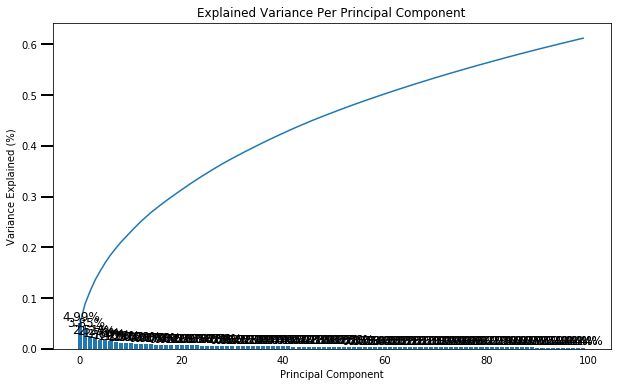

In [113]:
scree_plot(pca)
pca.explained_variance_ratio_.sum()

In [114]:
type(X_pca)

numpy.ndarray

In [115]:
dump(pca,'pca.model')

['pca.model']

In [116]:
dump(X_pca,'xpca.numpy')

['xpca.numpy']

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer 
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline
import pickle


### Discussion 2.2: Perform Dimensionality Reduction

I tried this both with all of the ordinal components included and then again removing the non-interval ordinal components.  Both ways i landed on reducing to 10 components.   10 compoents was about 80% of vairability  when using all 55 features, and about 88-90% using 17 features.  

I decided to remove the ordinal components that were not clearly interval, because it is unclear how the scoring was established.   

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [4]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.



In [118]:
#Modifeid version of function from helper_functions.py in MiniPCA 
def pca_results_rng(full_dataset, pca,dim_rng,pltpca=False):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    
    input: 
    full_dataset = is the full dataset that was transformed
    pca = is the fit_transformed pca
    dim_rng: list of size to of the first and last dimention to be displayed
    
    '''
    dim_rng[0] = dim_rng[0] - 1  #because first dimention is at index 0
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1, len(pca.components_)+1)]
    dim = dimensions[dim_rng[0]:dim_rng[1]]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    comp = components.iloc[dim_rng[0]:dim_rng[1]]

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    vr = variance_ratios.iloc[dim_rng[0]:dim_rng[1]]

    if pltpca == True:
        fig, ax = plt.subplots(figsize = (20,8))

        # Plot the feature weights as a function of the components
        comp.plot(ax = ax, kind = 'bar');
        ax.set_ylabel("Feature Weights")
        ax.set_xticklabels(dim, rotation=0)

        # Display the explained variance ratios
        for i, ev in enumerate(pca.explained_variance_ratio_):
            if int(i) >= dim_rng[0] and int(i) < dim_rng[1]:
                ax.text(i-dim_rng[0], ax.get_ylim()[1], "Explained Variance\n%.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([vr, comp], axis = 1)

In [119]:
res = pca_results_rng(df_azdias_wkg_cln,pca,[1,4])

In [120]:
res1 = res.drop(['Explained Variance'],axis=1)

In [222]:
res1.loc['Dimension 1',:].sort_values(ascending=False)[:5]

HEALTH_TYP_1.0              0.1590
SEMIO_VERT_4                0.1386
LP_LEBENSPHASE_FEIN_20.0    0.1316
FINANZ_UNAUFFAELLIGER_4     0.1261
EWDICHTE                    0.1225
Name: Dimension 1, dtype: float64

In [235]:
res1.loc['Dimension 1',:].sort_values(ascending=True)[:5]

ANZ_HAUSHALTE_AKTIV     -0.1464
ONLINE_AFFINITAET_2.0   -0.1415
PLZ8_BAUMAX_4.0         -0.1261
FINANZ_SPARER_3         -0.1243
BALLRAUM                -0.1083
Name: Dimension 1, dtype: float64

    HEALTH_TYP_1.0              0.1590 - Health Type - Critically Reserved 
    SEMIO_VERT_4                0.1386 - Personality Dreamer = Average
    LP_LEBENSPHASE_FEIN_20.0    0.1316 - Life Stage = top earner couples of higher age
    FINANZ_UNAUFFAELLIGER_4     0.1261 - Finance type - inconspicuouy low
    EWDICHTE                    0.1225 - Households per km^2

    ANZ_HAUSHALTE_AKTIV     -0.1464 - Number of households per building
    ONLINE_AFFINITAET_2.0   -0.1415 - Online affinity middle
    PLZ8_BAUMAX_4.0         -0.1261 - 10+ family holes within region
    FINANZ_SPARER_3         -0.1243 - Finance type - Saver - average
    BALLRAUM                -0.1083 - Distance to nearest urban center

Positive end - Wealthy older couples, non inconspucous spending, in dense area
Negative end - high number of households per building (apt building), far from urban center

In [122]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.



In [226]:
res1.loc['Dimension 2',:].sort_values(ascending=False)[:5]

ALTERSKATEGORIE_GROB    0.1836
LP_STATUS_FEIN_3.0      0.1479
W_KEIT_KIND_HH_2.0      0.1468
CAMEO_DEU_2015_3A       0.1458
FINANZ_MINIMALIST_3     0.1335
Name: Dimension 2, dtype: float64

In [234]:
res1.loc['Dimension 2',:].sort_values(ascending=True)[:5]

WOHNLAGE_8.0               -0.1524
LP_LEBENSPHASE_FEIN_12.0   -0.1195
FINANZTYP_5                -0.1195
PLZ8_BAUMAX_2.0            -0.1195
SEMIO_DOM_4                -0.1193
Name: Dimension 2, dtype: float64

    ALTERSKATEGORIE_GROB    0.1836 - Age based on name 
    LP_STATUS_FEIN_3.0      0.1479 - Social Status - aspiring low-income earners
    W_KEIT_KIND_HH_2.0      0.1468 - Likleyhood of children in household
    CAMEO_DEU_2015_3A       0.1458 - Wealth/Life State - Career and Family
    FINANZ_MINIMALIST_3     0.1335 - Finance Minimialist - average

    WOHNLAGE_8.0               -0.1524 - Neightboorhood quality - new bulding rural
    LP_LEBENSPHASE_FEIN_12.0   -0.1195 - Life Stage -  single homeowners at retirement age
    FINANZTYP_5                -0.1195 - Finance type - investor
    PLZ8_BAUMAX_2.0            -0.1195 - 3-5 family holmes within the PLZ8 region
    SEMIO_DOM_4                -0.1193 - Personality - Dominant minded average


Positive End: Older low income earners with childre.
NEgative end: Rural, older, single, moderate wealth (homeownserhsip and investor)

In [124]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.



In [229]:
res1.loc['Dimension 3',:].sort_values(ascending=False)[:5]

CAMEO_INTL_2015_WEALTH_5    0.1668
SEMIO_SOZ_5                 0.1479
SEMIO_KRIT_7                0.1469
LP_STATUS_GROB_3.0          0.1453
SEMIO_MAT_1                 0.1312
Name: Dimension 3, dtype: float64

In [236]:
res1.loc['Dimension 3',:].sort_values(ascending=True)[:5]

SEMIO_VERT_2          -0.2808
CAMEO_DEU_2015_1C     -0.1670
FINANZ_SPARER_2       -0.1527
LP_FAMILIE_GROB_2.0   -0.1468
CAMEO_DEU_2015_2B     -0.1458
Name: Dimension 3, dtype: float64

    CAMEO_INTL_2015_WEALTH_5    0.1668 - Poorer households
    SEMIO_SOZ_5                 0.1479 - Personality - Social minded low
    SEMIO_KRIT_7                0.1469 - Personality - Critical minded lowest
    LP_STATUS_GROB_3.0          0.1453 - Social status - independents (middle earners)
    SEMIO_MAT_1                 0.1312 - Personality - Materialistic Highest

    SEMIO_VERT_2          -0.2808 - Personality - Dreamful very high
    CAMEO_DEU_2015_1C     -0.1670 - Wealth/Life - Successful Songwriter
    FINANZ_SPARER_2       -0.1527 - Finance Saver = high
    LP_FAMILIE_GROB_2.0   -0.1468 - Family size - Couple
    CAMEO_DEU_2015_2B     -0.1458 - Wealth/Life - Noble Jogger

Pos end:  Lower to middle income, materialistic
Neg end: Aspirational, saving couples

In [231]:
res1.loc['Dimension 4',:].sort_values(ascending=False)[:5]

GEBAEUDETYP_6.0            0.1867
SEMIO_SOZ_5                0.1777
SEMIO_RAT_1                0.1773
LP_STATUS_GROB_5.0         0.1616
LP_LEBENSPHASE_GROB_6.0    0.1481
Name: Dimension 4, dtype: float64

In [237]:
res1.loc['Dimension 4',:].sort_values(ascending=True)[:5]

GEBAEUDETYP_RASTER_3.0   -0.1457
W_KEIT_KIND_HH_2.0       -0.1356
PLZ8_ANTG1_0.0           -0.1353
CAMEO_DEU_2015_3A        -0.1295
FINANZ_MINIMALIST_4      -0.1283
Name: Dimension 4, dtype: float64

    GEBAEUDETYP_6.0            0.1867 - Type of building - mixed building without actually known household
    SEMIO_SOZ_5                0.1777 - Personality - Socially minded low 
    SEMIO_RAT_1                0.1773 - Personality - Rational highest
    LP_STATUS_GROB_5.0         0.1616 - Social Status - top earners
    LP_LEBENSPHASE_GROB_6.0    0.1481 - Life Stage - Single parents

    GEBAEUDETYP_RASTER_3.0   -0.1457 - ratio of res to commercial - mixed with middle business share
    W_KEIT_KIND_HH_2.0       -0.1356 - Likelyhood of children - very likely
    PLZ8_ANTG1_0.0           -0.1353 - no 1-2 family homes
    CAMEO_DEU_2015_3A        -0.1295 - Wealth/Life - Career & Family
    FINANZ_MINIMALIST_4      -0.1283 - Fiance - low interest - low

Pos End: High earners, singlee parents, apartment building
NEg End: Families living in mixed residential/commerical areas

### Discussion 2.3: Interpret Principal Components

The first eigenvector represents on:
    
    Positive End: Older low income earners with childre.
    NEgative end: Rural, older, single, moderate wealth (homeownserhsip and investor)

The second eigenvector represents:
    
    Positive End: Older low income earners with childre.
    NEgative end: Rural, older, single, moderate wealth (homeownserhsip and investor)
    
The third eigennvector represents on:
    
    Pos end:  Lower to middle income, materialistic
    Neg end: Aspirational, saving couples


The forth eigenvector represents on:

    Pos End: High earners, singlee parents, apartment building
    NEg End: Families living in mixed residential/commerical areas

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [127]:
from sklearn.cluster import KMeans
import time

In [128]:
#Earlier runs of this notebook, I accidently forgot to use the toy_dataset.  Left the output intact for future referene

In [129]:
DF_XPCA = pd.DataFrame(X_pca)
toy_dataset = DF_XPCA.sample(n=int(X_pca.shape[0]*0.05))

In [33]:
# A place for your work - create a scree plot - you will need to
# Fit a kmeans model with changing k from 1-10
# Obtain the score for each model (take the absolute value)
# Plot the score against k
centers = []
scores = []

In [ ]:
## Used this to help manage the interupts.  , udacity kept crappig out on me after 2-3 cycles.  Taking several days to run this
## Note: Duh this is because I ran this cell using full dataset, well atleast I have the data now
for ii in range(1,31):
    
    k_pick = open('kdict.pickle',"rb")
    k_dict = pickle.load(k_pick)
    scores = k_dict['scores']
    centers = k_dict['centers']
    
    if ii>=centers[len(centers)-1]:
        time1 = time.time()
        print('Fitting ',ii,' kmean centers ')
        kmeans = KMeans(ii)
        model = kmeans.fit(DF_XPCA.values)
        labels = model.predict(DF_XPCA.values)
        centers.append(ii)
        scores.append(abs(model.score(DF_XPCA.values)))
        time2 = (time.time() - time1)/60
        print('Loop ',ii,' took ', time2, ' minutes to complete')
        
        k_dict = {'scores': scores,
                 'centers': centers}

        k_pick = open('kdict.pickle',"wb")
        pickle.dump(k_dict,k_pick)
        

Fitting  29  kmean centers 


In [35]:
#Open the original ouput

In [130]:
import pickle

In [131]:
k_pick = open('kdict.pickle',"rb")
k_dict2 = pickle.load(k_pick)

scores = k_dict2['scores']
centers = k_dict2['centers']

In [132]:
#removing the repeats created by restarts (i.e. i wrote the loop logic incorrectly)
kmeans_scores = pd.DataFrame({'centers': centers,'scores': scores})
kmeans_scores = kmeans_scores.drop_duplicates('centers')

In [133]:
## realizing i forgot to use a toy dataset, trying this again
centers_t = []
scores_t = []

for ii in range(1,31):
    
    if ii>1:
        k_pick_t = open('kdict_t.pickle',"rb")
        k_dict_t = pickle.load(k_pick_t)
        scores_t = k_dict_t['scores']
        centers_t = k_dict_t['centers']
    
    #if ii>=centers_t[len(centers_t)-1]:
    time1 = time.time()
    print('Fitting ',ii,' kmean centers ')
    kmeans_t = KMeans(ii)
    model_t = kmeans_t.fit(toy_dataset.values)
    labels_t = model_t.predict(toy_dataset.values)
    centers_t.append(ii)
    scores_t.append(abs(model_t.score(toy_dataset)))
    time2 = (time.time() - time1)/60
    print('Loop ',ii,' took ', time2, ' minutes to complete')

    k_dict_t = {'scores': scores_t,
             'centers': centers_t}

    k_pick_t = open('kdict_t.pickle',"wb")
    pickle.dump(k_dict_t,k_pick_t)

Fitting  1  kmean centers 
Loop  1  took  0.01567661762237549  minutes to complete
Fitting  2  kmean centers 
Loop  2  took  0.04520062208175659  minutes to complete
Fitting  3  kmean centers 
Loop  3  took  0.06564472913742066  minutes to complete
Fitting  4  kmean centers 
Loop  4  took  0.08098551829655966  minutes to complete
Fitting  5  kmean centers 
Loop  5  took  0.10209359327952067  minutes to complete
Fitting  6  kmean centers 
Loop  6  took  0.1452326734860738  minutes to complete
Fitting  7  kmean centers 
Loop  7  took  0.14804726839065552  minutes to complete
Fitting  8  kmean centers 
Loop  8  took  0.13391281763712565  minutes to complete
Fitting  9  kmean centers 
Loop  9  took  0.18372735977172852  minutes to complete
Fitting  10  kmean centers 
Loop  10  took  0.15173831780751545  minutes to complete
Fitting  11  kmean centers 
Loop  11  took  0.1608871301015218  minutes to complete
Fitting  12  kmean centers 
Loop  12  took  0.1632006883621216  minutes to complete
F

In [134]:
k_means_t = pd.DataFrame({'centers':centers_t,'scores':scores_t})

In [135]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

## Compared full dataset v toy dataset(5%) as well


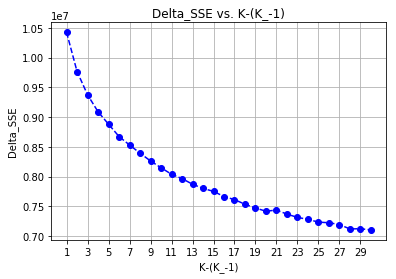

In [136]:
#5% sample
plt.plot(k_means_t['centers'],k_means_t['scores'], linestyle='--', marker='o', color='b');
plt.xlabel('K-(K_-1)');
plt.ylabel('Delta_SSE');
plt.xticks(np.arange(1,30,step=2));
plt.grid()
plt.title('Delta_SSE vs. K-(K_-1)');

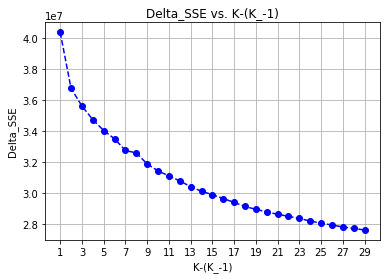

In [137]:
#Full Dataset
plt.plot(kmeans_scores['centers'],kmeans_scores['scores'], linestyle='--', marker='o', color='b');
plt.xlabel('K-(K_-1)');
plt.ylabel('Delta_SSE');
plt.xticks(np.arange(1,30,step=2));
plt.grid()
plt.title('Delta_SSE vs. K-(K_-1)');

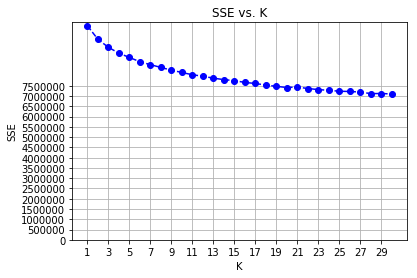

In [138]:
#5% Dataset - Scaled to 0
plt.plot(k_means_t['centers'],k_means_t['scores'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.xticks(np.arange(1,30,step=2));
plt.yticks(np.arange(0,8e6,0.5e6))
plt.grid()
plt.title('SSE vs. K');

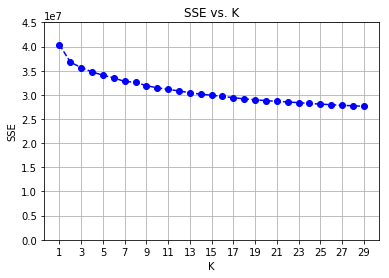

In [139]:
#Full Dataset - Scaled to 0
plt.plot(kmeans_scores['centers'],kmeans_scores['scores'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.xticks(np.arange(1,30,step=2));
plt.yticks(np.arange(0,5e7,step=0.5e7))
plt.grid()
plt.title('SSE vs. K');

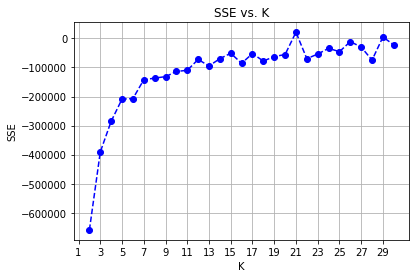

In [140]:
#5% Dataset - Differences Plotted
plt.plot(k_means_t['centers'],k_means_t.diff()['scores'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.xticks(np.arange(1,30,step=2));
plt.grid()
plt.title('SSE vs. K');

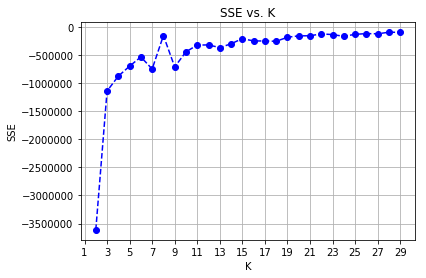

In [141]:
#Full Dataset - Differences Plotted
plt.plot(kmeans_scores['centers'],kmeans_scores['scores'].diff(), linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.xticks(np.arange(1,30,step=2));
plt.grid()
plt.title('SSE vs. K');

In [142]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Select 6 centers per the differences plots
kmeans_6 = KMeans(6)
k_model = kmeans_6.fit(DF_XPCA.values)
labels = k_model.predict(DF_XPCA.values)

In [143]:
dump(k_model,'k_model.model')

['k_model.model']

### Discussion 3.1: Apply Clustering to General Population
I didnt mean to, but i forgot to use my toy dataset as the quick samples.  Took many attempts and several days to run the 30 k-means, but the scan was using the entire dataset.

It is diffecult to determine to elbow from the standard graph so I used the difference between the errors of clusters to find a point where the changes between thepoints begins to slow down.   I chose 6 clusters as the elbow point.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer 
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline
import pickle


In [145]:
# Load in the customer demographics data.
customers = pd.read_pickle('cust_wkg.pickle')  #from earlier pre-processes data

In [146]:
set(df_azdias_wkg_cln.columns)-set(customers.columns)

set()

In [147]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

from joblib import dump, load
 
#load models
## imputer 
i_mean= load('i_mean.model')
i_mf = load('i_mf.model')
## scaler
scaler = load('scaler.model')
## pca
pca = load('pca.model')
## kmeans 
k_model = load('k_model.model')

In [148]:
#impute  


cust_wkg,imf,im = impute_data(customers,feat_wkg,imp_most_freq=i_mf,imp_mean=i_mean)
#note - added the az_wkg after reloading notebook to avoid rerunning evertyhing from ckpt 6
#az_wkg,imf_a,im_a = impute_data(azdias_wkg,feat_wkg,imp_most_freq=i_mf,imp_mean=i_mean)

In [149]:
#Scale imputed data

cust_scaled = scaler.transform(cust_wkg)
#az_scaled = scaler.transform(az_wkg)


In [150]:
###############
#  Dimentionality Reduction using PCA
##############

cust_pca = pca.transform(cust_scaled)
#az_pca = pca.transform(az_scaled)

In [151]:
##############
#  Cluster
##############

c_labels = k_model.predict(cust_pca)
#a_labels = k_model.predict(az_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [152]:
import seaborn as sns

In [153]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
c_count = np.unique(c_labels,return_counts=True)
c_prop = c_count[1]/c_count[1].sum()

az_l_count = np.unique(labels,return_counts=True)
az_l_prop = az_l_count[1]/az_l_count[1].sum()

In [154]:
props = pd.DataFrame(c_prop,columns=['customer'])


In [155]:
props['gen pop'] = az_l_prop


In [156]:
cust_scaled.shape

(133427, 455)

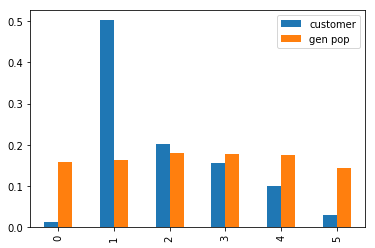

In [157]:
props.plot(kind='bar')

In [ ]:
s

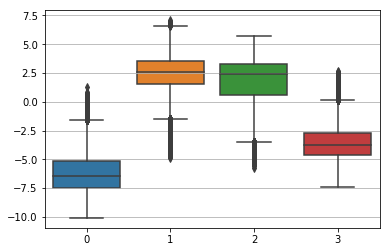

In [214]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#There was a single cluster that significantly was overrepresented in the customer dateset
# Cluster 1
clust1 = np.where(c_labels==1)
cpca_clust1 = pd.DataFrame(cust_pca[clust1])

ax = sns.boxplot(data=cpca_clust1[list(range(0,4,1))])
ax.grid(axis='y')

In [215]:
clust1_mean = cpca_clust1[list(range(0,4,1))].mean()

In [216]:
clust2_mean

0   -6.123310
1    2.499311
2    1.480240
3   -3.494444
dtype: float64

In [159]:
## NOTE this graph is index 0 but pca components are index 1
##  Cluster 1 has a low score on pca component 1(0) and 4(3) and high on 2(1) and 3(2)

In [160]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Cluster  0,5,4 

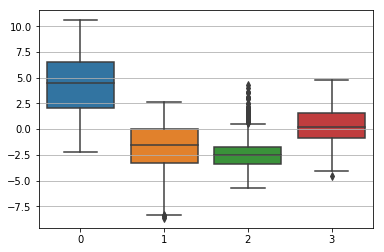

In [217]:
# Cluster 0
clust0 = np.where(c_labels==0)
cpca_clust0 = pd.DataFrame(cust_pca[clust0])

ax0 = sns.boxplot(data=cpca_clust0[list(range(0,4,1))])
ax0.grid(axis='y')

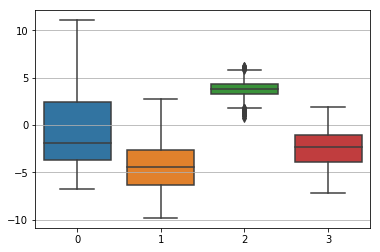

In [218]:
# Cluster 5
clust5 = np.where(c_labels==5)
cpca_clust5 = pd.DataFrame(cust_pca[clust5])

ax2 = sns.boxplot(data=cpca_clust5[list(range(0,4,1))])
ax2.grid(axis='y')

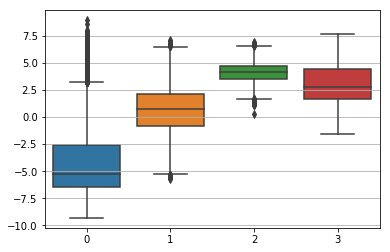

In [220]:
# Cluster 2
clust4 = np.where(c_labels==4)
cpca_clust4 = pd.DataFrame(cust_pca[clust4])

ax3 = sns.boxplot(data=cpca_clust2[list(range(0,4,1))])
ax3.grid(axis='y')

In [221]:
clust5_mean = cpca_clust5[list(range(0,4,1))].mean()
clust4_mean = cpca_clust4[list(range(0,4,1))].mean()
clust0_mean = cpca_clust0[list(range(0,4,1))].mean()

In [ ]:
#To find the features that most represent the cluster, i will take the scores 

In [178]:
first4 = res1.iloc[:4,:]

In [244]:
first4.sum(axis=1)

Dimension 1   -1.0475
Dimension 2   -0.8732
Dimension 3   -0.1611
Dimension 4   -0.3296
dtype: float64

In [199]:
cl1 = np.reshape(clust1_mean,[4,1])
cl1.shape

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


(4, 1)

In [207]:
(cl1*first4).sum().sort_values(ascending=False)[:10]

W_KEIT_KIND_HH_2.0        1.254642
CAMEO_DEU_2015_3A         1.189235
ALTERSKATEGORIE_GROB      1.016395
SEMIO_KRIT_6              1.006986
KBA05_ANTG3_0.0           1.006461
PLZ8_ANTG1_0.0            0.981841
REGIOTYP_3.0              0.971453
GEBAEUDETYP_RASTER_1.0    0.965136
FINANZ_SPARER_3           0.960482
FINANZTYP_2               0.849150
dtype: float64

In [238]:
cl1

array([[-6.12330994],
       [ 2.49931096],
       [ 1.4802405 ],
       [-3.49444374]])

In [240]:
cl0 = np.reshape(clust0_mean,[4,1])
(cl0*first4).sum().sort_values(ascending=False)[:10]

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


SEMIO_VERT_2              0.760475
HH_EINKOMMEN_SCORE_4.0    0.736872
FINANZ_HAUSBAUER_1        0.728693
SEMIO_KULT_3              0.640752
HEALTH_TYP_1.0            0.628616
LP_FAMILIE_GROB_2.0       0.617479
CAMEO_DEU_2015_1C         0.602393
WOHNLAGE_8.0              0.587878
HH_EINKOMMEN_SCORE_2.0    0.581348
FINANZ_HAUSBAUER_2        0.556400
dtype: float64

In [239]:
cl5 = np.reshape(clust5_mean,[4,1])
(cl5*first4).sum().sort_values(ascending=False)[:10]

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


SEMIO_DOM_4                 1.254600
FINANZTYP_5                 1.252629
LP_LEBENSPHASE_FEIN_12.0    1.252629
PLZ8_BAUMAX_2.0             1.252629
GEBAEUDETYP_RASTER_3.0      0.905341
SEMIO_ERL_3                 0.867392
WOHNLAGE_8.0                0.778737
KBA05_ANTG2_0.0             0.755270
W_KEIT_KIND_HH_6.0          0.728262
LP_LEBENSPHASE_FEIN_14.0    0.718079
dtype: float64

In [241]:
cl4 = np.reshape(clust4_mean,[4,1])
(cl4*first4).sum().sort_values(ascending=False)[:10]

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


SEMIO_VERT_2              0.908126
GEBAEUDETYP_RASTER_5.0    0.766774
ONLINE_AFFINITAET_2.0     0.744087
FINANZ_SPARER_2           0.733196
ANZ_HAUSHALTE_AKTIV       0.717716
PLZ8_BAUMAX_4.0           0.661865
GEBAEUDETYP_1.0           0.626751
CAMEO_DEU_2015_2B         0.597125
BALLRAUM                  0.568796
ANZ_TITEL                 0.567021
dtype: float64

In [ ]:
first4.sort_values(ascending=False)

### Discussion 3.3: Compare Customer Data to Demographics Data

Per the previous section, I chose 6 clusters for the K-means model.   I evaluated the customer data versus the gen pop data and identified one cluseter (cluster 1) where the customers were overrepresentged in comparison to the gen pop data.  Alternatvly there were 3 clusters that the custers were underrepresented in comparisont to the general population (Clusters 0,5 and 4).

I created box plots of each pca scores of each cluster.  I compared the means against the interpretations from section 2.2

Also as an alternative method (not sure if this is right) I took the means from each eigenvector within the evaluated cluster and multiplied across that eigenvector.   Then i added the each of the products of each of the four features together. (i.e. used the means as scalar magnitues multipliing across the respective eigenvectors)  I was hoping this would give me a better view on how the different means within each cluster pushed adn pulled with each other.


Cluster #1: Had significantly  higher proportion of customers in comparison to the general population. The average of the first 4 components within the clusters were as followed [-6, 2.5, 1.5, -3.5].  

It appears that the overrepresented demographic is Middle class families, potentially upper middle class in an urban area or apt building.

Clusters #s 0 5 and 4 had significantly lower proportion of customer in comparison to the gen pop

Note: interesting that all three clusters, although had different means, had a very tight distribution on component 3.

Cluster 0: means approx [5,-1,-2.5,0]
Couples without children, middle to upper middle class, not homeownsers.  Potnentially highly cultural midened/dreamer

Cluster 5: means approx [-0.5,-4.5,4,-2.5]
Single or Couple without children, savers or investors

Clsuter 2: means appox [-5, 0.5,4,2.5]
Livning in a residential area far from urban center,lower to middle income, savers.

The first eigenvector represents on:
    
    Positive end - Wealthy older couples, non inconspucous spending, in dense area
    Negative end - high number of households per building (apt building), far from urban center

The second eigenvector represents:
    
    Positive End: Older low income earners with childre.
    NEgative end: Rural, older, single, moderate wealth (homeownserhsip and investor)
    
The third eigennvector represents on:
    
    Pos end:  Lower to middle income, materialistic
    Neg end: Aspirational, saving couples


The forth eigenvector represents on:

    Pos End: High earners, singlee parents, apartment building
    NEg End: Families living in mixed residential/commerical areas
    
    
I have trouble with this last part, i am only semi in that I performed the analysis correctly.  I found looking at the top and bottom of the eigenvectors a bit cryptic.  Which is why i used the second method.  
    

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.